Hidden units regions

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from model import ShallowNeuralNetwork

def hidden_unit_linear_regions(hidden_unit, phi, axes, titles, color):
    ax1, ax2, ax3 = axes
    linear_func  = lambda x: hidden_unit.theta0 + hidden_unit.theta1 * x

    for ax in axes:
        ax.plot([0,2], [0,0], color="#abb2b9", linestyle="--")

    ax1.plot([0, 2], [linear_func(0), linear_func(2)], color=color)
    ax1.text(1., -0.85, titles[0], horizontalalignment='center',
             verticalalignment='center', color=color)
    ax2.text(1., -0.85, titles[1], horizontalalignment='center',
             verticalalignment='center', color=color)
    ax3.text(1., -0.85, titles[2], horizontalalignment='center',
             verticalalignment='center', color=color)

    t = np.linspace(0,2,50)
    ax2.plot(t, [hidden_unit(x) for x in t], color=color)
    ax3.plot(t, [phi*hidden_unit(x) for x in t], color=color)


phi_1 =  0.2
phi_2 = -0.8
phi_3 =  0.7
phi_4 =  0.4
h_1: Hidden Unit: (-0.2,  0.3)
h_2: Hidden Unit: (-0.9,  0.8)
h_3: Hidden Unit: ( 1.0, -0.6)


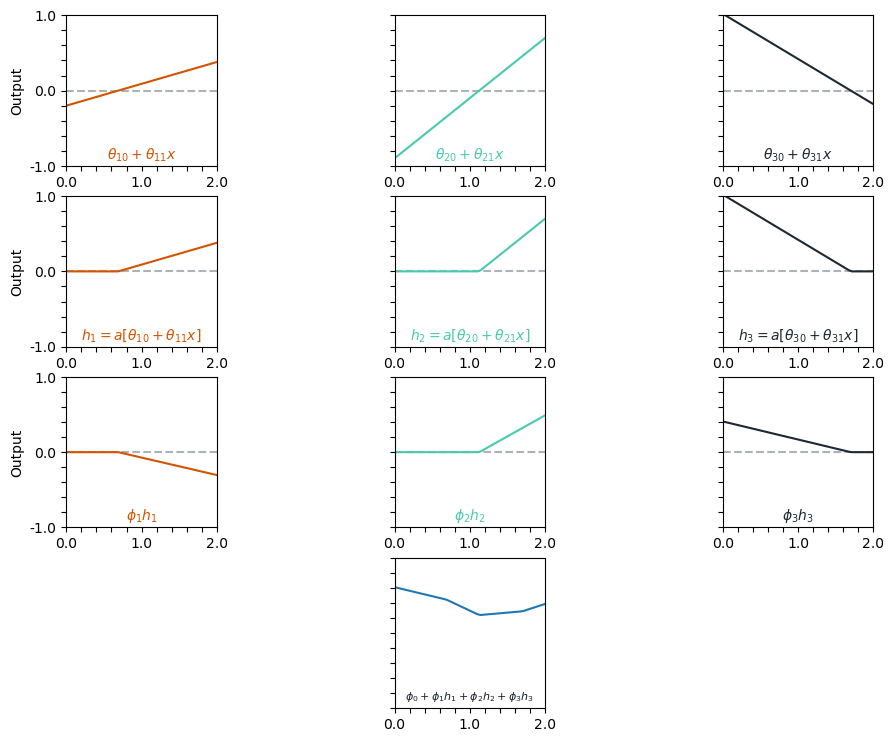

In [38]:
neural_network = ShallowNeuralNetwork(params=[0.2, -0.8, 0.7, 0.4],
                                        hidden_units_params=[(-0.2, 0.29), (-0.9, 0.8), (1.02, -0.6)])

for i,p in enumerate(neural_network.params):
    print("phi_%d = %4.1f" % (i+1, p))

fig, axes = plt.subplots(4,3, figsize=(12, 9), dpi=100)

for i, (h,color) in enumerate(zip(neural_network.hidden_units, ["#d35400", "#48c9b0", "#1c2833"])):
    print(f"h_{i+1}:", h)
    titles = [rf"$\theta_{{{i+1}0}} + \theta_{{{i+1}1}} x$",
                rf"$h_{i+1} = a[\theta_{{{i+1}0}} + \theta_{{{i+1}1}} x]$",
                rf"$\phi_{i+1} h_{i+1}$"]
    hidden_unit_linear_regions(h, phi=neural_network.params[i+1],
                                axes=[axes[0,i], axes[1,i], axes[2,i]],
                                titles=titles,
                                color=color)
for i,ax in enumerate(axes.ravel()):
    ax.set_aspect('equal')
    ax.set_xlim([0, 2])
    ax.set_ylim([-1, 1])
    ax.set_xticks(ticks=np.arange(0,2.2,0.2), labels=["0.0"]+['']*4+["1.0"]+['']*4+["2.0"])
    if i%3==0:
        ax.set_yticks(ticks=np.arange(-1,1.2,0.2), labels=["-1.0"]+['']*4+["0.0"]+['']*4+["1.0"])
    else:
        ax.set_yticks(ticks=np.arange(-1,1.2,0.2), labels=['']*11)
    if i%3==0: ax.set_ylabel("Output")

axes[3,0].axis("off")
axes[3,2].axis("off")

t = np.linspace(0,2,50)
axes[3,1].plot(t, [neural_network(x) for x in t])
axes[3,1].text(1., -0.85, r"$\phi_0 + \phi_1 h_1 + \phi_2 h_2 + \phi_3 h_3$", horizontalalignment='center',
            verticalalignment='center', color="#17202a", fontsize=8)

plt.show()

Implementation from scratch

In [39]:
import torch

class LinearDataset(torch.utils.data.Dataset):
    def __init__(self, w, b, n, noise=0.01):
        self.w = w
        self.b = b
        noise = noise * torch.randn(n, 1)
        self.X = torch.randn(n, len(w))
        self.y = torch.matmul(self.X, w.reshape(-1,1)) + b + noise
    
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

    def __len__(self): return len(self.X)

In [40]:
class LinearModel:
    def __init__(self, num_inputs):
        self.w = torch.normal(mean=0., std=0.01, size=(num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)

    def forward(self, x):
        return torch.matmul(x, self.w) + self.b

    def __call__(self, x): return self.forward(x)

In [41]:
class SGD:
    def __init__(self, params, lr):
        self.params = params
        self.lr = lr
    
    def step(self):
        for p in self.params:
            p -= self.lr * p.grad

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()

In [50]:
def train(model, criterion, data, epochs, optimizer):
    track_loss = []
    for i in range(epochs):
        epoch_loss = 0
        for batch in data:
            loss = criterion(model(*batch[:-1]), batch[-1])
            optimizer.zero_grad()
            loss.backward()
            with torch.no_grad():
                optimizer.step()
            epoch_loss += loss.item()
        epoch_loss /= len(data)
        track_loss.append(epoch_loss)
        print("Epoch: %d, loss: %f" % (i+1, epoch_loss))
    plt.plot(track_loss); plt.show()

num of batches:  63
Params to estimate are:
w: tensor([1.3000, 0.6000]) , b: tensor([4.9000])
Before training:
w: [[-0.00376273]
 [-0.00284311]] , b: 0.0
Epoch: 1, loss: 470.024026
Epoch: 2, loss: 132.898181
Epoch: 3, loss: 37.703911
Epoch: 4, loss: 10.710138
Epoch: 5, loss: 3.055774
Epoch: 6, loss: 0.867675
Epoch: 7, loss: 0.248820
Epoch: 8, loss: 0.073033
Epoch: 9, loss: 0.022976
Epoch: 10, loss: 0.008788


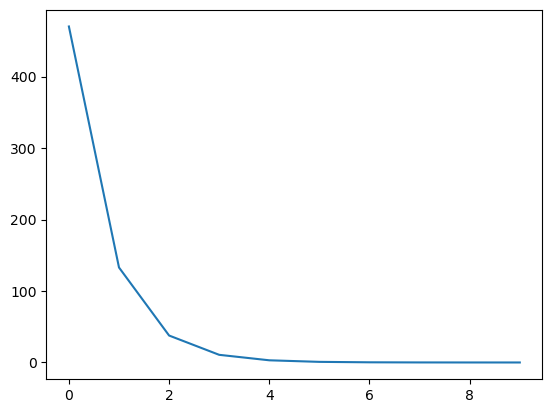

After training
w: [[1.2981873]
 [0.5979406]] , b: 4.890873908996582


In [51]:
data = LinearDataset(w=torch.tensor([1.3, 0.6]),
                        b=torch.tensor([4.9]), n=1000, noise=0.01)
dataloader = torch.utils.data.DataLoader(dataset=data, shuffle=True, batch_size=16, num_workers=4)
print("num of batches: ", len(dataloader))
model = LinearModel(num_inputs=2)
optimizer = SGD(params=[model.w, model.b], lr=0.01)
criterion = lambda x,y: ((x-y)**2 / 2).mean()

print("Params to estimate are:")
print("w:", dataloader.dataset.w, ", b:", dataloader.dataset.b)
print("Before training:")
print("w:", model.w.detach().numpy(), ", b:", model.b.item())
train(model, criterion, dataloader, 10, optimizer)
print("After training")
print("w:", model.w.detach().numpy(), ", b:", model.b.item())

Concise implementation

In [44]:
import torch
import torch.nn as nn
class ConciseLinearModel(nn.Module):
    def __init__(self, input_size: int, output_size: int, init=True):
        super().__init__()
        self.net = nn.Linear(in_features=input_size, out_features=output_size)
        if init:
            self.net.bias.data.fill_(0)
            self.net.weight.data.normal_(mean=0, std=1)
    def forward(self, x): return self.net(x)

In [45]:
model = ConciseLinearModel(input_size=2, output_size=1, init=False)
print("Bias:", model.net.bias)
print("Weight:", model.net.weight)
model.net.bias.data.fill_(0)
model.net.weight.data.normal_(mean=0, std=1)
print("Bias:", model.net.bias)
print("Weight:", model.net.weight)

Bias: Parameter containing:
tensor([0.2303], requires_grad=True)
Weight: Parameter containing:
tensor([[ 0.0436, -0.1652]], requires_grad=True)
Bias: Parameter containing:
tensor([0.], requires_grad=True)
Weight: Parameter containing:
tensor([[-0.0399, -1.5923]], requires_grad=True)


In [56]:
def train(model, data, criterion, optimizer, epochs):
    track_loss = []
    for i in range(epochs):
        epoch_loss = 0
        for batch in data:
            loss = criterion(model(*batch[:-1]), batch[-1])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss
        epoch_loss /= len(data)
        track_loss.append(epoch_loss.item())
        print("Epoch: %d, loss: %f" % (i+1, epoch_loss))
    plt.plot(track_loss); plt.show()

Params to estimate are:
w: tensor([ 2.3000, -2.3000]) , b: tensor([-8])
Before training:
w: [[-1.5084192 -1.5957553]] , b: 0.0
Epoch: 1, loss: 29.352617
Epoch: 2, loss: 2.195496
Epoch: 3, loss: 0.167164
Epoch: 4, loss: 0.012792
Epoch: 5, loss: 0.001075
Epoch: 6, loss: 0.000170
Epoch: 7, loss: 0.000101
Epoch: 8, loss: 0.000095
Epoch: 9, loss: 0.000095
Epoch: 10, loss: 0.000095


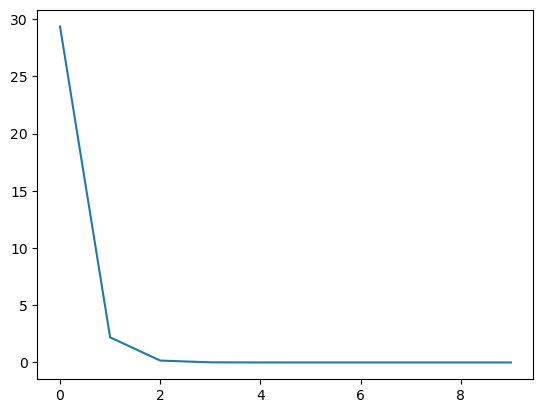

After training
w: [[ 2.3001459 -2.3005142]] , b: -8.000521659851074


In [57]:
data = LinearDataset(w=torch.tensor([2.3, -2.3]),
                        b=torch.tensor([-8]), n=1000, noise=0.01)
dataloader = torch.utils.data.DataLoader(dataset=data, shuffle=True, batch_size=16, num_workers=4)
model = ConciseLinearModel(input_size=2, output_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)
print("Params to estimate are:")
print("w:", dataloader.dataset.w, ", b:", dataloader.dataset.b)
print("Before training:")
print("w:", model.net.weight.data.detach().numpy(), ", b:", model.net.bias.data.item())
train(model=model, data=dataloader, criterion=criterion, optimizer=optimizer, epochs=10)
print("After training")
print("w:", model.net.weight.data.detach().numpy(), ", b:", model.net.bias.data.item())